**Задача**: предсказать, содержатся ли в тексте объявления контактные данные.

# Preparation

## Importing libraries

In [0]:
import os
import re
import numpy as np
import pandas as pd
import lightgbm as lgb
import scipy.sparse
from scipy.sparse import csr_matrix, hstack
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading data

In [0]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984487 entries, 0 to 984486
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               984487 non-null  object 
 1   description         984487 non-null  object 
 2   subcategory         984487 non-null  object 
 3   category            984487 non-null  object 
 4   price               926439 non-null  float64
 5   region              984487 non-null  object 
 6   city                984487 non-null  object 
 7   datetime_submitted  984487 non-null  object 
 8   is_bad              984487 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 67.6+ MB


In [0]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16237 entries, 0 to 16236
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               16237 non-null  object 
 1   description         16237 non-null  object 
 2   subcategory         16237 non-null  object 
 3   category            16237 non-null  object 
 4   price               15374 non-null  float64
 5   region              16237 non-null  object 
 6   city                16237 non-null  object 
 7   datetime_submitted  16237 non-null  object 
 8   is_bad              16237 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 1.1+ MB


In [0]:
with pd.option_context('display.max_colwidth', -1):
  display(train.sample(10))

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
330770,Роликии с защитой,комлекта роликов размер 48 с комплектом защиты в сумке.,Спорт и отдых,Хобби и отдых,5000.0,Краснодарский край,Краснодар,2019-07-15 14:12:36.171778,0
887692,Свадебная шубка,"Укороченная шубка из искусственного меха, рукав до середины локтя. Размер 14-11","Одежда, обувь, аксессуары",Личные вещи,500.0,Рязанская область,Рязань,2019-09-27 21:23:00.636090,0
179508,Щенки в добрые руки,"Здоровые щенки, 3 мес. Смесь лабрадора и овчарки/\nЗвонить по номеру тел. +7967-134-89-74",Собаки,Животные,NaN,Краснодарский край,Сочи,2019-06-23 18:10:01.444462,1
894275,"ВАЗ 16099, 1001","На запчасти , заводиться , все вопросы по телефону 89563020335/\nКоробка и движок в порядке /\nТорг приветствуется",Автомобили,Транспорт,20000.0,Татарстан,Казань,2019-09-28 17:20:57.978784,1
348277,Горный велосипед челенджер генесис,"на ходу все работает ,камера колеса в подорок .",Велосипеды,Хобби и отдых,8000.0,Россия,Москва,2019-07-17 18:45:21.040645,0
160304,Продам учебник по биологии 9 класс,"Учебник по биологии 9 класс ФГОС. Данилова,Романова 4051 год",Товары для детей и игрушки,Личные вещи,300.0,Орловская область,Орёл,2019-06-21 11:45:18.670358,0
302603,Британские котята вислоухие,"6 котёнка от британки (мама на последнем фото). Все девочки, 1 вислоухая, 1 прямоухая",Кошки,Животные,NaN,Тамбовская область,Тамбов,2019-07-11 08:58:28.277367,0
593306,Спиральные сверла по дереву,"спиральные сверла 10*540, 68*400, 68*640, 64*540, 65*540, все сверла новые некоторые покрылись налетом потому что долго лежали первое значение диаметр, второе значение длинна.",Ремонт и строительство,Для дома и дачи,1000.0,Красноярский край,Красноярск,2019-08-20 15:32:16.726103,0
115634,Межкомнатные двери,межкомнатные двери 1 деревянные двери по 30см цена 1000,Ремонт и строительство,Для дома и дачи,2000.0,Татарстан,Нижнекамск,2019-06-15 20:51:15.496358,0
266005,Фасадчик,"Описание работодателя:/\n/\nСтроительной компании требуется звено на фасадные работы. Коттеджное строительство. /\n/\nТребования:/\n/\n- Опыт работы с каменной ватой; /\n- Нанесение декоративных камешковых штукатурок ""барашек"". /\n- Приветствуются специалисты с опытом работы на вент фасадах./\n/\nУсловия:/\n/\n- Официальное трудоустройство/\n- Еженедельные авансы и выдача зарплаты два раза в месяц по объемам выполненых работ (сдельная зарплата)/\n- обеспечение спец одеждой и всем необходимым инструментом/\n/\nЖилье и питание не предоставляется, транспортные расходы не возмещаются. Посредники не беспокойте",Вакансии,Работа,60000.0,Крым,Ялта,2019-07-06 10:19:55.914766,0


# Features

## Classes

### Substring matching

In [0]:
class SubstringMatcher(BaseEstimator, TransformerMixin):
  def __init__(self, subs, **kwargs):
    self.subs = subs
    super().__init__(**kwargs)

  def fit(self, X, y=None):
    return self
  
  def has_substring(self, sub):
    def fn(str):  
      if str.lower().find(sub) > 0:
        return 1
      else:
        return 0
    return fn

  def transform(self, X, y=None):
    res = []
    for sub in self.subs:
      res.append(csr_matrix(X.apply(self.has_substring(sub))).T)
    return hstack(res, format='csr', dtype=np.float64)

  def get_feature_names(self):
    return self.subs

In [0]:
class RegexMatcher(BaseEstimator, TransformerMixin):
  def __init__(self, funcs, **kwargs):
    self.funcs = funcs
    super().__init__(**kwargs)

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    res = []
    for func in self.funcs:
      res.append(csr_matrix(X.apply(func)).T)
    return hstack(res, format='csr', dtype=np.float64)

  def get_feature_names(self):
    return [x.__name__ for x in self.funcs]


def number(s):
  if re.search(r'(\d.*){6,11}', s):
    return 1
  else:
    return 0

def number2(s):
  if re.match(r'\d{6,11}', re.sub('\D', '', s)):
    return 1
  else:
    return 0
    
def number3(s):
  if re.search(r'\d{6,11}', re.sub('\s', '', s)):
    return 1
  else:
    return 0

### Tokenizing

In [0]:
def tokenizer(s):
  s = re.sub(r'\W', ' ', s)
  s = re.sub(r'_', '', s)
  s = re.sub(r'(?<=\d)(\D)', r' \1', s)
  s = re.sub(r'(\D)(?=\d)', r'\1 ', s)
  s = re.sub(r'\d', '0', s)
  return s.lower().split()

### Passthrough class for feature names

In [0]:
class Passthrough(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    self.columns = X.columns
    return self
  
  def transform(self, X, y=None):
    return X

  def get_feature_names(self):
    return self.columns

## Features Pipeline

In [0]:
%%time

pipeline = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['subcategory', 'category', 'region']),
    (CountVectorizer(min_df=1000, token_pattern=r'.+'), 'city'),
    (Passthrough(), ['price']),
    (SubstringMatcher(subs=['+', 'звон', '@']), 'description'),
    (RegexMatcher(funcs=[number, number2, number3]), 'description'),
    (CountVectorizer(min_df=1000,
                     analyzer='word',
                     ngram_range=(1,2),
                     tokenizer=tokenizer), 'description'),
    )

X_train = pipeline.fit_transform(train.drop(columns=['is_bad']))
X_test = pipeline.transform(val.drop(columns=['is_bad']))
  
y_train = train.is_bad
y_test = val.is_bad

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')

X_train: (984487, 11861), X_test: (16237, 11861)
CPU times: user 6min 42s, sys: 6.86 s, total: 6min 49s
Wall time: 6min 49s


# Model training

In [0]:
model = lgb.LGBMClassifier(num_leaves=2**10-1,
                           max_depth=-1,
                           learning_rate=0.1,
                           n_estimators=500,
                           min_data_in_leaf=40,
                           feature_fraction=0.95,
                           bagging_freq=7,
                           bagging_fraction=0.5,
                           metric='auc',
                           is_unbalance=True,
                           random_state=42)
%time model.fit(X_train,
                y_train,
                eval_set=[(X_train, y_train),
                          (X_test, y_test)],
                eval_metric='auc',
                verbose=10,
                early_stopping_rounds=30)

Training until validation scores don't improve for 30 rounds
[10]	training's auc: 0.979545	valid_1's auc: 0.956911
[20]	training's auc: 0.98369	valid_1's auc: 0.963597
[30]	training's auc: 0.987035	valid_1's auc: 0.968107
[40]	training's auc: 0.989746	valid_1's auc: 0.971275
[50]	training's auc: 0.991631	valid_1's auc: 0.9733
[60]	training's auc: 0.993124	valid_1's auc: 0.97476
[70]	training's auc: 0.9942	valid_1's auc: 0.975502
[80]	training's auc: 0.995062	valid_1's auc: 0.97609
[90]	training's auc: 0.995744	valid_1's auc: 0.97657
[100]	training's auc: 0.996348	valid_1's auc: 0.976712
[110]	training's auc: 0.99683	valid_1's auc: 0.976801
[120]	training's auc: 0.997212	valid_1's auc: 0.976635
[130]	training's auc: 0.997584	valid_1's auc: 0.976751
Early stopping, best iteration is:
[106]	training's auc: 0.996643	valid_1's auc: 0.976843
CPU times: user 48min, sys: 9.83 s, total: 48min 10s
Wall time: 12min 14s


# Results

## Learning curves, overall ROC AUC

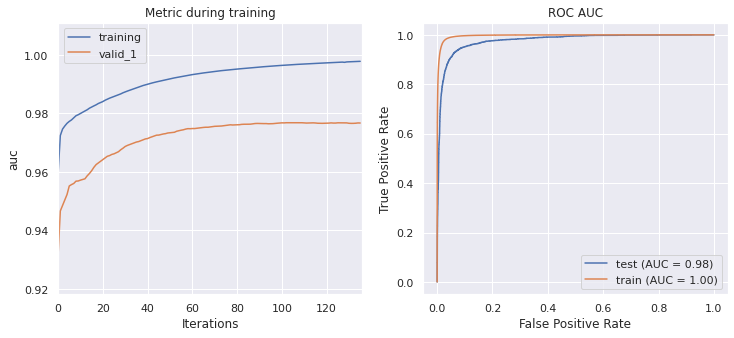

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax2.set_title('ROC AUC')
lgb.plot_metric(model, metric='auc', ax=ax1)
plot_roc_curve(model, X_test, y_test, name='test', ax=ax2)
plot_roc_curve(model, X_train, y_train, name='train', ax=ax2)

## ROC AUC by category

In [0]:
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=y_test.index)
roc_auc_by_category = dict()
for category in train.category.astype('category').dtype.categories:
  idx = val[val.category == category].index
  roc_auc = roc_auc_score(y_test[idx], y_pred[idx])
  roc_auc_by_category[category] = roc_auc
  print(f'{category}: {roc_auc:0.2f}')
print(f'Средний ROC AUC: {np.mean(list(roc_auc_by_category.values())):0.2f}')

Бытовая электроника: 0.95
Для бизнеса: 0.96
Для дома и дачи: 0.96
Животные: 0.95
Личные вещи: 0.87
Недвижимость: 0.99
Работа: 0.94
Транспорт: 0.99
Услуги: 0.92
Хобби и отдых: 0.95
Средний ROC AUC: 0.95


## Feature importances

In [0]:
with pd.option_context('display.float_format', '{:.0f}'.format):
  feature_names = pipeline.get_feature_names()
  display(pd.Series(model.booster_.feature_importance(importance_type='gain'),
                    index=feature_names).sort_values(ascending=False).head(50))

countvectorizer-2__00000000000             824996
countvectorizer-2__000 00                  326111
countvectorizer-2__ru                      233330
countvectorizer-2__звонить                 173776
countvectorizer-2__com                     145941
countvectorizer-2__00                      144220
countvectorizer-2__восемь                  129221
passthrough__price                         119820
regexmatcher__number                       116975
countvectorizer-2__ру                      99250 
countvectorizer-2__тел                     88361 
countvectorizer-2__0000                    73777 
countvectorizer-2__000                     64310 
onehotencoder__x0_Запчасти и аксессуары    63074 
countvectorizer-2__0                       57315 
countvectorizer-2__00 00                   57221 
onehotencoder__x1_Бытовая электроника      47402 
regexmatcher__number2                      40796 
countvectorizer-2__в                       39184 
countvectorizer-2__0 000                   38506 
